## Import Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import functions as funk

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm

from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor #lightgbm

## Functions

In [2]:
#def get_model_results(model_name, y, preds):
    #print(f'The accuracy of the {model_name} is {r2_score(y,preds)}')
    #print(f'RMSE is : {mean_squared_error(y,preds)}')
    #print(f'MAE is  : {mean_absolute_error(y,preds)}')

## Import and Looking at Competition Data

In [3]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

### Looking at the DataFrame Index

In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Looking at Our Modeling Target (SalePrice)

In [5]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

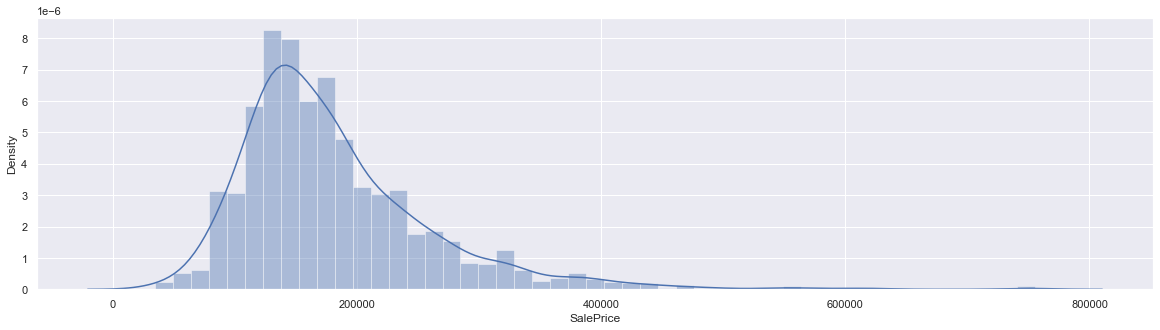

In [6]:
# Look at the distribution of 'SalePrice' by plotting it as a histogram
sns.set(rc = {'figure.figsize':(20,5)})
sns.distplot(train['SalePrice']);

In [7]:
# Looking at numerical descriptors of the shape (skewness and kurtosis) of the distribution of train['SalePrice]
skewness = train['SalePrice'].skew()
kurtosis = train['SalePrice'].kurtosis()
print(f'Skewness : {skewness}')
print(f'Kurtosis : {kurtosis}')

Skewness : 1.8828757597682129
Kurtosis : 6.536281860064529


In [8]:
# Use np.log() to transform train.SalePrice and calculate the skewness and kurtosis again
target = np.log(train.SalePrice)
skewness = target.skew()
kurtosis = target.kurtosis()
print(f'Skewness : {skewness}')
print(f'Kurtosis : {kurtosis}')

Skewness : 0.12133506220520406
Kurtosis : 0.8095319958036296


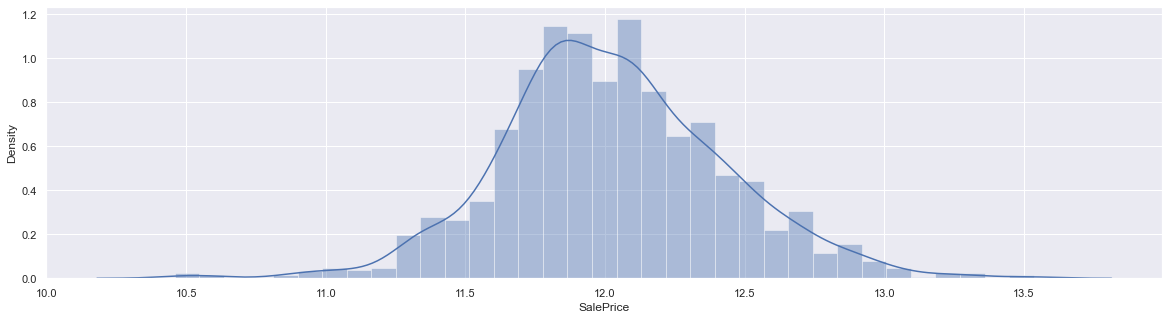

In [9]:
# Look at the distribution of target by plotting it as a histogram
sns.set(rc = {'figure.figsize':(20,5)})
sns.distplot(target);

### Working with Numeric Features

In [10]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [11]:
# Highest and lowest correlations with SalePrice
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:7], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


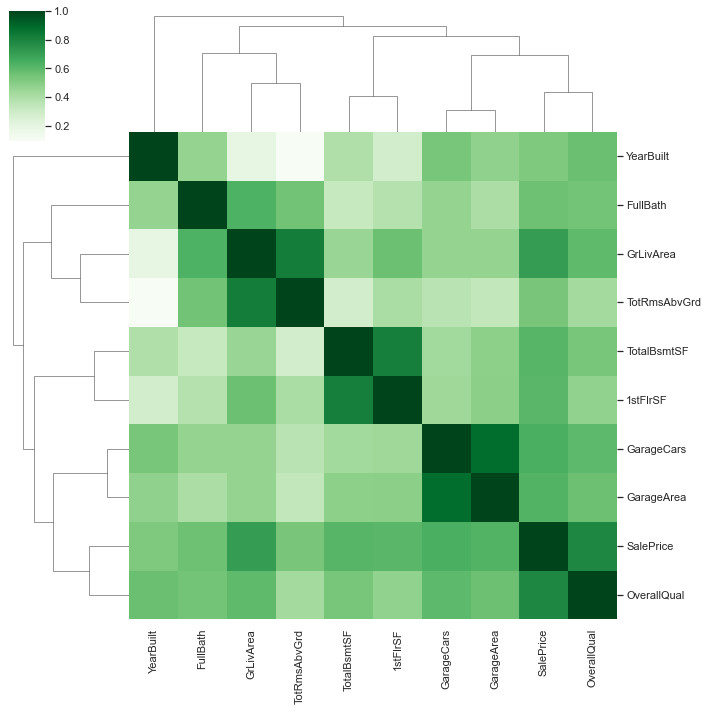

In [12]:
# SalePrice Correlation Matrix

k=10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.00)
hm = sns.clustermap(cm, cmap = "Greens",cbar = True, square = True, yticklabels = cols.values, xticklabels = cols.values)

### Identifying Outliers in the Highest Correlated Features in train.csv

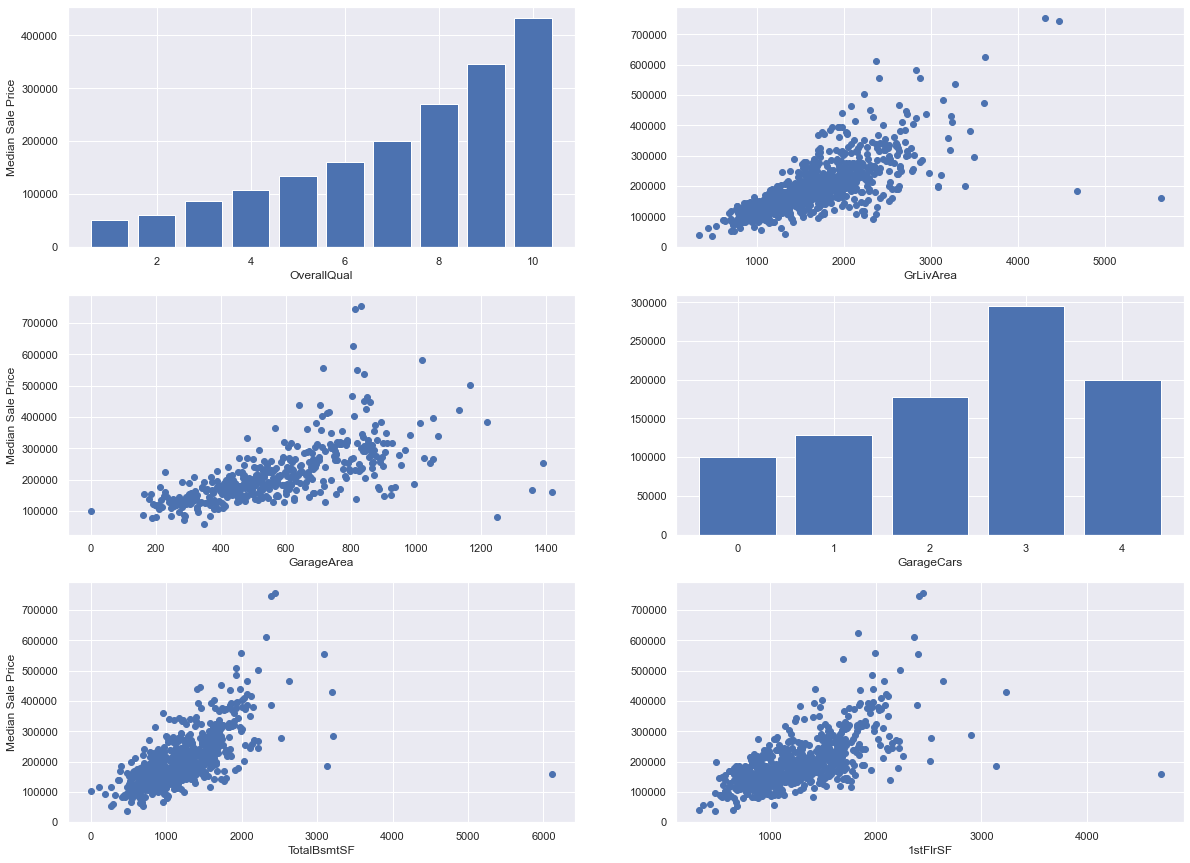

In [13]:
# Take a look at the relationship between SalePrice and the most highly correlated features

OverallQual_pivot = train.pivot_table(index='OverallQual',values='SalePrice', aggfunc=np.median)
GrLivArea_pivot = train.pivot_table(index='GrLivArea',values='SalePrice', aggfunc=np.median)
GarageCars_pivot = train.pivot_table(index='GarageCars',values='SalePrice', aggfunc=np.median)
GarageArea_pivot = train.pivot_table(index='GarageArea',values='SalePrice', aggfunc=np.median)
TotalBsmtSF_pivot = train.pivot_table(index='TotalBsmtSF',values='SalePrice', aggfunc=np.median)
FstFlrSF_pivot = train.pivot_table(index='1stFlrSF',values='SalePrice', aggfunc=np.median)

fig, ax = plt.subplots(3,2,figsize=(20,15))
ax[0,0].bar(OverallQual_pivot.index, OverallQual_pivot["SalePrice"], color='b')
ax[0,0].set_xlabel("OverallQual")
ax[0,1].scatter(GrLivArea_pivot.index, GrLivArea_pivot["SalePrice"], color='b', edgecolor='b')
ax[0,1].set_xlabel('GrLivArea')
ax[1,0].scatter(GarageArea_pivot.index, GarageArea_pivot["SalePrice"], color='b', edgecolor='b')
ax[1,0].set_xlabel("GarageArea")
ax[1,1].bar(GarageCars_pivot.index, GarageCars_pivot["SalePrice"])
ax[1,1].set_xlabel("GarageCars")
ax[2,0].scatter(TotalBsmtSF_pivot.index, TotalBsmtSF_pivot["SalePrice"], color='b', edgecolor='b')
ax[2,0].set_xlabel("TotalBsmtSF")
ax[2,1].scatter(FstFlrSF_pivot.index, FstFlrSF_pivot["SalePrice"], color='b', edgecolor='b')
ax[2,1].set_xlabel("1stFlrSF")

ax[0,0].set_ylabel('Median Sale Price')
ax[1,0].set_ylabel('Median Sale Price')
ax[2,0].set_ylabel('Median Sale Price')
#ax.title('SalePrice in relation to heighest correlated features')
#plt.xticks(rotation=90)
plt.show()

## Some Feature Engineering

In [14]:
train['Total_Bathrooms'] = (train['FullBath'] + (0.5 * train['HalfBath']) + train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']))

test['Total_Bathrooms'] = (test['FullBath'] + (0.5 * test['HalfBath']) + test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']))

train['TotalSF'] = (train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF'])

test['TotalSF'] = (test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF'])

In [15]:
# Highest and lowest correlations with SalePrice
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:7], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice          1.000000
OverallQual        0.790982
TotalSF            0.782260
GrLivArea          0.708624
GarageCars         0.640409
Total_Bathrooms    0.631731
GarageArea         0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


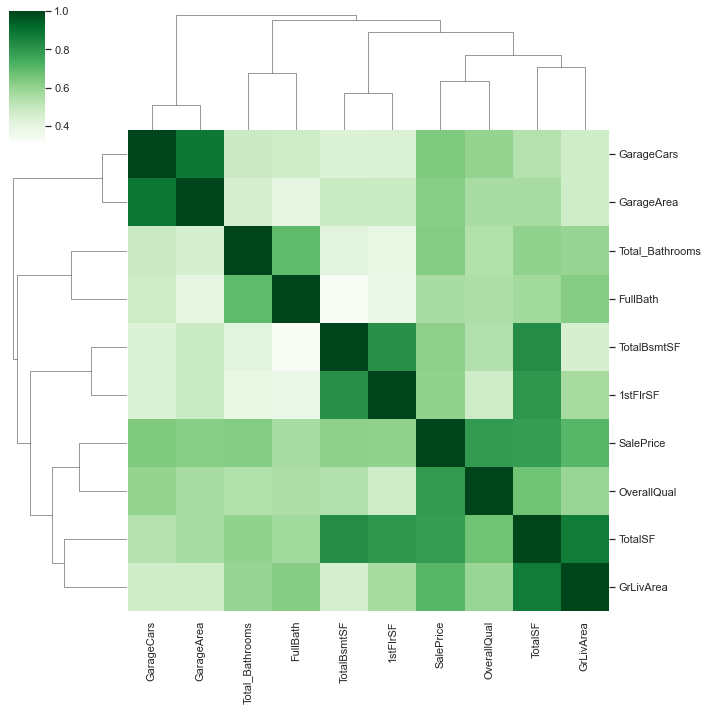

In [16]:
# SalePrice Correlation Matrix

k=10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.00)
hm = sns.clustermap(cm, cmap = "Greens",cbar = True, square = True, yticklabels = cols.values, xticklabels = cols.values)

In [17]:
# Remove Outliers
train = train[train['GrLivArea'] < 4600]
train = train[train['GarageArea'] < 1220]

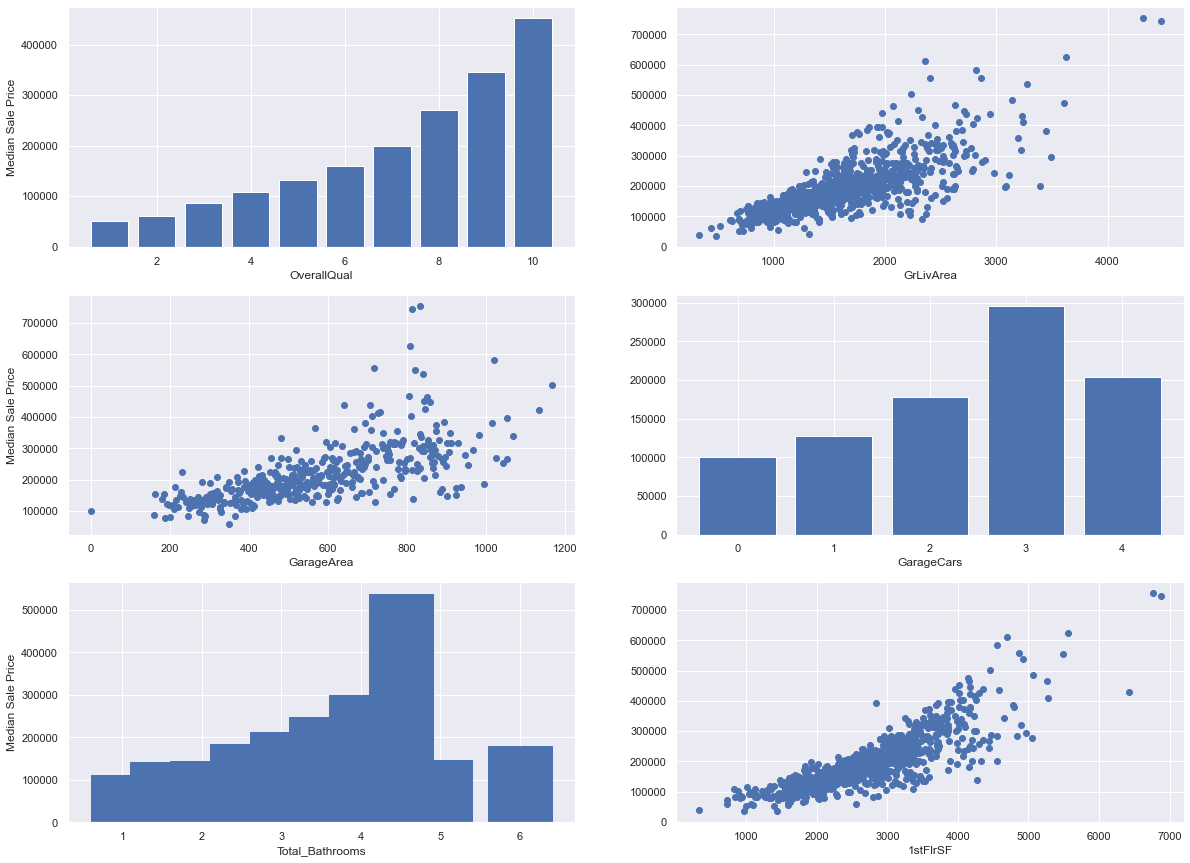

In [18]:
# Take a look at the relationship between SalePrice and the most highly correlated features

OverallQual_pivot = train.pivot_table(index='OverallQual',values='SalePrice', aggfunc=np.median)
GrLivArea_pivot = train.pivot_table(index='GrLivArea',values='SalePrice', aggfunc=np.median)
GarageCars_pivot = train.pivot_table(index='GarageCars',values='SalePrice', aggfunc=np.median)
GarageArea_pivot = train.pivot_table(index='GarageArea',values='SalePrice', aggfunc=np.median)
Total_Bathrooms_pivot = train.pivot_table(index='Total_Bathrooms',values='SalePrice', aggfunc=np.median)
TotalSF_pivot = train.pivot_table(index='TotalSF',values='SalePrice', aggfunc=np.median)

fig, ax = plt.subplots(3,2,figsize=(20,15))
ax[0,0].bar(OverallQual_pivot.index, OverallQual_pivot["SalePrice"], color='b')
ax[0,0].set_xlabel("OverallQual")
ax[0,1].scatter(GrLivArea_pivot.index, GrLivArea_pivot["SalePrice"], color='b', edgecolor='b')
ax[0,1].set_xlabel('GrLivArea')
ax[1,0].scatter(GarageArea_pivot.index, GarageArea_pivot["SalePrice"], color='b', edgecolor='b')
ax[1,0].set_xlabel("GarageArea")
ax[1,1].bar(GarageCars_pivot.index, GarageCars_pivot["SalePrice"])
ax[1,1].set_xlabel("GarageCars")
ax[2,0].bar(Total_Bathrooms_pivot.index, Total_Bathrooms_pivot["SalePrice"], color='b', edgecolor='b')
ax[2,0].set_xlabel("Total_Bathrooms")
ax[2,1].scatter(TotalSF_pivot.index, TotalSF_pivot["SalePrice"], color='b', edgecolor='b')
ax[2,1].set_xlabel("1stFlrSF")

ax[0,0].set_ylabel('Median Sale Price')
ax[1,0].set_ylabel('Median Sale Price')
ax[2,0].set_ylabel('Median Sale Price')
#ax.title('SalePrice in relation to heighest correlated features')
#plt.xticks(rotation=90)
plt.show()

In [19]:
# Remove features made redundant by the engineered features
train = train.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'], axis=1)
test = test.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'], axis=1)

train = train.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1)
test = test.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1)

In [20]:
# Missing Data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total,percent], axis = 1, keys = ['Total','Percentage'])
missing_data.head(20)

,Total,Percentage
PoolQC,1448,0.995873
MiscFeature,1401,0.963549
Alley,1363,0.937414
Fence,1173,0.806740
FireplaceQu,689,0.473865
LotFrontage,258,0.177442
GarageQual,81,0.055708
GarageFinish,81,0.055708
GarageYrBlt,81,0.055708
GarageType,81,0.055708


## Working with Non-Numeric Features

In [21]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1454,1454,91,1454,1454,1454,1454,1454,1454,1454,...,1373,1373,1373,1373,1454,6,281,53,1454,1454
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1146,1449,50,921,1309,1453,1047,1377,225,1257,...,867,605,1305,1320,1334,2,157,48,1266,1196


In [22]:
cate = test.select_dtypes(exclude=[np.number])
cate.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1459,107,1459,1459,1457,1459,1459,1459,1459,...,1383,1381,1381,1381,1459,3,290,51,1458,1459
unique,5,2,2,4,4,1,5,3,25,9,...,6,3,4,5,3,2,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1114,1453,70,934,1311,1457,1081,1396,218,1251,...,853,625,1293,1328,1301,2,172,46,1258,1204


In [23]:
# Some feature engineering/feature modification

train['Bsmt'] = (train['BsmtQual'] + train['BsmtCond'])
test['Bsmt'] = (test['BsmtQual'] + test['BsmtCond'])

train['Garage'] = (train['GarageQual'] + train['GarageCond']) 
test['Garage'] = (test['GarageQual'] + test['GarageCond']) 

train['External'] = (train['ExterQual'] + train['ExterCond']) 
test['External'] = (test['ExterQual'] + test['ExterCond'])

In [24]:
cols = ('FireplaceQu', 'Bsmt', 'Garage', 'External', 'KitchenQual', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
         'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold','YearRemodAdd')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))
    lbl.fit(list(test[c].values)) 
    test[c] = lbl.transform(list(test[c].values))

### Cleaning Missing Data

In [25]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
test = test.select_dtypes(include=[np.number]).interpolate().dropna()

### Create train_X, val_X, train_y, and val_y

In [26]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice','Id'], axis=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1)

## Start Modeling

In [27]:
model_results = pd.DataFrame(columns = ['model_name', 'run', 'run_notes', 'accuracy', 'RMSE', 'MAE'])

### Linear Regresssion

In [28]:
# Create linear regression object
model_name = 'Linear Regression'
y_pred, model_scores, regr = funk.run_linear_regression(train_X, train_y, val_X, val_y)

funk.get_model_results(model_name, val_y, y_pred)
model_results = model_results.append(model_scores)

The accuracy of the Linear Regression is 0.9094247922469045
RMSE is : 0.015558834789809859
MAE is  : 0.08673399309458407


### XGBoost

model_name = 'XGBoost'

n_splits_val = 3
preds, model_scores, xg_model = funk.run_xgboost(n_splits_val,train_X,train_y,val_X,val_y)

funk.get_model_results(model_name, val_y, preds)
model_results = model_results.append(model_scores);

In [29]:
n_splits_val = 3
kfolds = KFold(n_splits=n_splits_val, shuffle=False)

### Gradient Boosting Regressor

In [30]:
model_name = 'Gradient Boosted Regressor'
gbr_preds, model_scores, gbr_model = funk.run_gbr(train_X,train_y,val_X,val_y)

funk.get_model_results(model_name, val_y, gbr_preds)
model_results = model_results.append(model_scores)

The accuracy of the Gradient Boosted Regressor is 0.9162849452514374
RMSE is : 0.014380410915571509
MAE is  : 0.08058357511133211


### LightGBM

In [31]:
model_name = 'LightGBM'

lgbm_preds, model_scores, lgbm_model = funk.run_lgbm(train_X,train_y,val_X,val_y)

funk.get_model_results(model_name, val_y, lgbm_preds)
model_results = model_results.append(model_scores)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
The accuracy of the LightGBM is 0.918307516946076
RMSE is : 0.014032977444226788
MAE is  : 0.0808426278168599


### RidgeCV

In [32]:
model_name = 'ridge Regression'

ridge_preds, model_scores, ridge_model = funk.run_ridgecv(n_splits_val, train_X,train_y,val_X,val_y)

model_results = model_results.append(model_scores)
funk.get_model_results(model_name, val_y, ridge_preds)

The accuracy of the ridge Regression is 0.9091227832208243
RMSE is : 0.01561071331880669
MAE is  : 0.08693953829853039


### LassoCV

In [33]:
model_name = 'ridge Regression'

alphas2 = [1, 0.1, 0.001, 0.0005]

lasso_preds, model_scores, lasso_model = funk.run_lassocv(n_splits_val, alphas2, train_X,train_y,val_X,val_y)

model_results = model_results.append(model_scores)
funk.get_model_results(model_name, val_y, lasso_preds)


The accuracy of the ridge Regression is 0.9096448344318477
RMSE is : 0.015521036366960499
MAE is  : 0.08717567855990553


### ElasticNetCV

In [34]:
model_name = "ElasticNetCV"

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_preds, model_scores, elastic_model = funk.run_elasticnetcv(n_splits_val,e_l1ratio, e_alphas, train_X,train_y,val_X,val_y)

model_results = model_results.append(model_scores)
funk.get_model_results(model_name, val_y, elastic_preds)

The accuracy of the ElasticNetCV is 0.9090062755091958
RMSE is : 0.015630726789180482
MAE is  : 0.0872475658300282


In [35]:
print(model_results)

                    model_name run run_notes  accuracy      RMSE       MAE
0            Linear Regression   1      None  0.909425  0.015559  0.086734
0  Gradient Boosted Regression   1      None  0.916285  0.014380  0.080584
0                     LightGBM   1      None  0.918308  0.014033  0.080843
0              ridge Regressor   1      None  0.909123  0.015611  0.086940
0                      LassoCV   1      None  0.909645  0.015521  0.087176
0                 ElasticNetCV   1      None  0.909006  0.015631  0.087248


In [36]:
model1_name = 'StackedCVRegressor'
model2_name = 'StackedCVWeighted'

# Set RidgeCV parameters
n_splits_val = 3
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1]

# Set LassoCV parameters
alphas2 = [1, 0.1, 0.001, 0.0005]

# Set ElasticNetCV parameters
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

stack_gen_preds, model_scores1, stack_gen_model, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds = funk.run_stackedregressor(n_splits_val, r_alphas, alphas2, e_alphas, e_l1ratio, train_X, train_y, val_X, val_y)

model_results = model_results.append(model_scores1)
funk.get_model_results(model1_name, val_y, stack_gen_preds)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] 

In [37]:
# Stack 1
weights = [0.1,0.1,0.2,0.4,0.2]
this_run = 1

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [38]:
# Stack 2
weights = [0.1,0.1,0.15,0.5,0.15]
this_run = 2

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [39]:
# Stack 3
weights = [0.1,0.2,0.15,0.4,0.15]
this_run = 3

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [40]:
# Stack 4
weights = [0.1,0.2,0.15,0.3,0.25]
this_run = 4

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [41]:
# Stack 5
weights = [0.1,0.25,0.15,0.35,0.15]
this_run = 5

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [42]:
# Stack 6
weights = [0.5,0.2,0.1,0.1,0.1]
this_run = 6

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [43]:
# Stack 7
weights = [0.5,0.1,0.2,0.1,0.1]
this_run = 7

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [44]:
# Stack 8
weights = [0.5,0.1,0.1,0.2,0.1]
this_run = 8

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [45]:
# Stack 9
weights = [0.5,0.1,0.1,0.1,0.2]
this_run = 9

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [46]:
# Stack 10
weights = [0.2,0.5,0.1,0.1,0.1]
this_run = 10

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [47]:
# Stack 11
weights = [0.1,0.5,0.2,0.1,0.1]
this_run = 11

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [48]:
# Stack 12
weights = [0.1,0.4,0.1,0.2,0.1]
this_run = 12

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [49]:
# Stack 13
weights = [0.1,0.4,0.1,0.1,0.2]
this_run = 13

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [50]:
# Stack 15
weights = [0.1,0.2,0.4,0.1,0.1]
this_run = 15

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [51]:
# Stack 16
weights = [0.1,0.1,0.4,0.2,0.1]
this_run = 5

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [52]:
# Stack 14.
weights = [0.2,0.1,0.4,0.1,0.1]
this_run = 14

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [53]:
# Stack 17
weights = [0.1,0.1,0.4,0.1,0.2]
this_run = 17

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [54]:
# Stack 18
weights = [0.2,0.1,0.1,0.4,0.1]
this_run = 18

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [55]:
# Stack 19
weights = [0.1,0.2,0.1,0.4,0.1]
this_run = 19

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [56]:
# Stack 20
weights = [0.1,0.1,0.2,0.4,0.1]
this_run = 20

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [57]:
# Stack 21
weights = [0.1,0.1,0.1,0.4,0.2]
this_run = 21

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [58]:
# Stack 22
weights = [0.2,0.1,0.1,0.1,0.4]
this_run = 22

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [59]:
# Stack 23
weights = [0.2,0.1,0.1,0.1,0.4]
this_run = 5

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [60]:
# Stack 24
weights = [0.2,0.1,0.1,0.1,0.4]
this_run = 5

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [61]:
# Stack 25
weights = [0.2,0.1,0.1,0.1,0.4]
this_run = 5

stack_preds_run, model_scores = funk.run_stack_weighted_regressor(this_run, weights, em_preds, lasso_preds, ridge_preds, stack_gen_preds, lgbm_preds, gbr_preds, val_X, val_y)

model_results = model_results.append(model_scores)

In [62]:
print(model_results)

                    model_name run run_notes  accuracy      RMSE       MAE
0            Linear Regression   1      None  0.909425  0.015559  0.086734
0  Gradient Boosted Regression   1      None  0.916285  0.014380  0.080584
0                     LightGBM   1      None  0.918308  0.014033  0.080843
0              ridge Regressor   1      None  0.909123  0.015611  0.086940
0                      LassoCV   1      None  0.909645  0.015521  0.087176
0                 ElasticNetCV   1      None  0.909006  0.015631  0.087248
0           StackedCVRegressor   1      None  0.914318  0.014718  0.081956
0   Stacked Weighted Regressor   1      None  0.920564  0.013645  0.078863
0   Stacked Weighted Regressor   2      None  0.920384  0.013676  0.079093
0   Stacked Weighted Regressor   3      None  0.920763  0.013611  0.078955
0   Stacked Weighted Regressor   4      None  0.920749  0.013614  0.078898
0   Stacked Weighted Regressor   5      None  0.920730  0.013617  0.079023
0   Stacked Weighted Regr

In [63]:
feats = test.select_dtypes(include=[np.number]).interpolate().dropna()
feats = test.drop(['Id'], axis=1)

In [64]:
em_preds = elastic_model.predict(feats)
lasso_preds = lasso_model.predict(feats)
#ridge_preds = ridge_model.predict(feats)
stack_gen_preds = stack_gen_model.predict(feats)
lgbm_preds = lgbm_model.predict(feats)
gbr_preds = gbr_model.predict(feats)

In [65]:
stack_preds=((0.1*em_preds) + (0.1*lasso_preds) + (0.2 * gbr_preds ) 
               + (0.4*lgbm_preds) + (0.2*stack_gen_preds))

In [66]:
final_predictions = np.exp(stack_preds)
print ("Original predictions are: \n", stack_preds[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [11.71270154 11.92815242 12.1100459  12.19359781 12.02421277] 

Final predictions are: 
 [122112.92878005 151471.44801568 181687.94458769 197520.52980801
 166743.63106706]


In [67]:
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = final_predictions 
submission.to_csv('submission.csv', index=False)